# Competition Description
Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

But, it’s not always clear whether a person’s words are actually announcing a disaster

In [267]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#for text pre-processing
import re, string
import nltk
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
#for model-building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix,roc_auc_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
#for word embedding
import gensim
from gensim.models import Word2Vec

#model validation
from sklearn.model_selection import cross_val_score

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [268]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sample_submission = pd.read_csv("sample_submission.csv")

In [269]:
train.shape, test.shape, sample_submission.shape

((7613, 5), (3263, 4), (3263, 2))

In [270]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [271]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


# EDA

In [272]:
# WordCloud done before cleaning and preprocessing the data 

In [273]:
from wordcloud import WordCloud

In [274]:
comment_words =''
# stopwords = set(STOPWORDS)
for val in train['text']:
    val = str(val)
    tokens = val.split()
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
    
    comment_words += " ".join(tokens)+" "

In [275]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(comment_words)

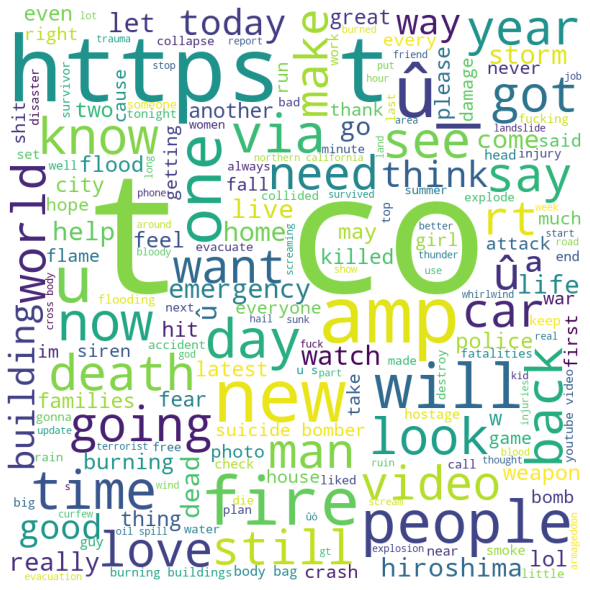

In [276]:
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

# Cleaning TEXT

In [277]:
#convert to lowercase, strip and remove punctuations
def preprocess(text):
    text = text.lower() 
    text=text.strip()  
    text=re.compile('<.*?>').sub('', text) 
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  
    text = re.sub('\s+', ' ', text)  
    text = re.sub(r'\[[0-9]*\]',' ',text) 
    text=re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) 
    text = re.sub(r'\s+',' ',text) 
    return text

In [278]:
# STOPWORD REMOVAL
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)

In [279]:
# Lemmatization 
lematize = WordNetLemmatizer() # stemmer = Porterstemmer()

In [280]:
def lemmatizing(word):
    lematize = WordNetLemmatizer()
    if(word!= lematize.lemmatize(word,pos='a')):
        return lematize.lemmatize(word,pos='a')
    elif(word!= lematize.lemmatize(word,pos='v')):
        return lematize.lemmatize(word,pos='v')
    else:
        return word

In [281]:
def finalpreprocess(string):
    return lemmatizing(stopword(preprocess(string)))
train['clean_text'] = train['text'].apply(lambda x: finalpreprocess(x))
train.head()

,id,keyword,location,text,target,clean_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deeds reason earthquake may allah forgive us
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,residents asked shelter place notified officer...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,people receive wildfires evacuation orders cal...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby alaska smoke wildfires pou...


In [282]:
comment_words =''
# stopwords = set(STOPWORDS)
for val in train['clean_text']:
    val = str(val)
    tokens = val.split()
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
    
    comment_words += " ".join(tokens)+" "

In [283]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(comment_words)

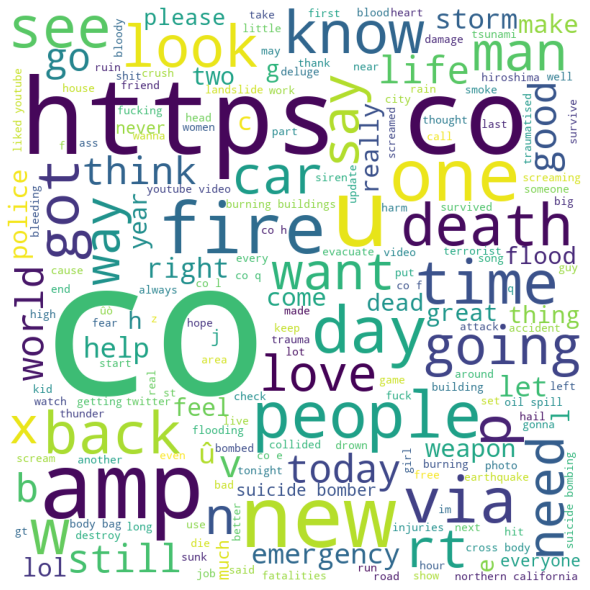

In [284]:
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

In [285]:
train.head()

,id,keyword,location,text,target,clean_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deeds reason earthquake may allah forgive us
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,residents asked shelter place notified officer...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,people receive wildfires evacuation orders cal...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby alaska smoke wildfires pou...


# Building a Model

### TF-idf Transformation

In [286]:
vector = TfidfVectorizer(sublinear_tf=True, max_features=2700)
X = vector.fit_transform(train['clean_text'].values)

In [287]:
X_col = vector.get_feature_names()

In [288]:
df = pd.DataFrame.sparse.from_spmatrix(X, columns = X_col)

In [289]:
df.head()

,aa,ab,aba,abandoned,abc,abcnews,ablaze,able,absolutely,abstorm,...,yu,yyc,zl,zombie,zone,åê,ûï,ûïwhen,ûò,ûó
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [290]:
df.shape

(7613, 2700)

In [291]:
test.shape

(3263, 4)

In [293]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [294]:
train_df = df.iloc[:7485]

In [295]:
train_df.shape

(7485, 2700)

In [296]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [297]:
train.head()

,id,keyword,location,text,target,clean_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deeds reason earthquake may allah forgive us
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,residents asked shelter place notified officer...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,people receive wildfires evacuation orders cal...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby alaska smoke wildfires pou...


In [298]:
Y = train['target']
train.drop('target', axis = 1, inplace = True)

In [299]:
Y = Y.iloc[:7485]

In [ ]:
cv = KFold(n_splits=10, random_state=1, shuffle=True)
# create model
model = LogisticRegression()
# evaluate model
scores = cross_val_score(model,train_df, Y, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: ',((scores).mean()))

In [ ]:
model.fit(train_df, Y)

In [ ]:
y_pred = model.predict(test)
y_pred.shape

In [229]:
test.shape

(128, 2700)

In [233]:
submit=pd.DataFrame()
submit = submit.iloc[:128]

In [239]:

submit['id'] = test_id
submit['target'] = y_pred # our model predictions on the test dataset


ValueError: Length of values (128) does not match length of index (3263)

In [236]:
submit.head()

,id
0,0
1,2
2,3
3,9
4,11


In [232]:
len(submit) == len(test)

True

In [47]:
#Logistic Regression for train data
logreg = LogisticRegression()

#fitting tf-idf
lr_tfidf = logreg.fit(X_train_vectors_tfidf,ytrain)
lr_tfidf_ypred = lr_tfidf.predict(X_test_vectors_tfidf)
lr_ypred_prob =  lr_tfidf.predict_proba(X_test_vectors_tfidf)

print(classification_report(ytest,lr_tfidf_ypred))

              precision    recall  f1-score   support

           0       0.78      0.87      0.83      1274
           1       0.81      0.70      0.75      1010

    accuracy                           0.80      2284
   macro avg       0.80      0.79      0.79      2284
weighted avg       0.80      0.80      0.79      2284



In [48]:
accuracy_lr_tf = accuracy_score(ytest,lr_tfidf_ypred)
accuracy_lr_tf

0.7955341506129597

In [49]:
#avg roc_auc_score
roc_auc_lrtf = np.mean(cross_val_score(estimator=logreg,X=X_train_vectors_tfidf,y=ytrain,scoring='roc_auc'))
roc_auc_lrtf

0.8463464377854695

In [54]:
#Naive bayes
mnb = MultinomialNB()
mnb_model = mnb.fit(X_train_vectors_tfidf,ytrain)
mnb_tfidf_ypred = mnb.predict(X_test_vectors_tfidf)

In [55]:
print(classification_report(ytest,mnb_tfidf_ypred))

              precision    recall  f1-score   support

           0       0.78      0.88      0.83      1274
           1       0.82      0.68      0.75      1010

    accuracy                           0.79      2284
   macro avg       0.80      0.78      0.79      2284
weighted avg       0.80      0.79      0.79      2284



In [56]:
accuracy_mnb = accuracy_score(ytest,mnb_tfidf_ypred)
accuracy_mnb

0.7937828371278459

In [57]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(mnb_model, X_train_vectors_tfidf,ytrain, cv=10, scoring="f1")
scores

array([0.73399015, 0.72139303, 0.71212121, 0.73658537, 0.72727273,
       0.71921182, 0.74654378, 0.72684086, 0.72180451, 0.71153846])

In [58]:
cross_val_mean_score = np.mean(scores)
cross_val_mean_score

0.7257301917242207

In [59]:
roc_auc_mnb = np.mean(cross_val_score(estimator=mnb, X=X_train_vectors_tfidf,y=ytrain,scoring='roc_auc'))
roc_auc_mnb

0.8464212684529577

In [60]:
models = ['Logistic Regression(tf-idf)','Naive Bayes']
accuracy = [accuracy_lr_tf,accuracy_mnb]
roc_auc = [roc_auc_lrtf, roc_auc_mnb]
model_dict = {'Model':models, 'Accuracy Score':accuracy, 'Avg. Roc_Auc_Score':roc_auc}
Submission = pd.DataFrame(model_dict)

In [61]:
Submission.sort_values(by=['Accuracy Score', 'Avg. Roc_Auc_Score'],ascending=False)

,Model,Accuracy Score,Avg. Roc_Auc_Score
0,Logistic Regression(tf-idf),0.795534,0.846346
1,Naive Bayes,0.793783,0.846421


In [64]:
sample_submission = pd.read_csv("sample_submission.csv")
sample_submission

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0
...,...,...
3258,10861,0
3259,10865,0
3260,10868,0
3261,10874,0


In [70]:
sample_submission.columns

Index(['id', 'target'], dtype='object')

In [88]:
test = pd.read_csv("test.csv")
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [89]:
test.columns

Index(['id', 'keyword', 'location', 'text'], dtype='object')

In [90]:
test.shape

(3263, 4)

In [76]:
train = pd.read_csv("train.csv")
train.columns

Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')

In [77]:
train.shape

(7613, 5)

In [78]:
train.drop('id', axis = 1, inplace = True)

In [79]:
test_id = test['id']

In [80]:
duplicates_record = train[train.duplicated(['text'], keep=False)]
duplicates_record

,keyword,location,text,target
40,ablaze,Live On Webcam,Check these out: http://t.co/rOI2NSmEJJ http:/...,0
48,ablaze,Live On Webcam,Check these out: http://t.co/rOI2NSmEJJ http:/...,0
106,aftershock,US,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/vA...,0
115,aftershock,US,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/vA...,0
118,aftershock,Switzerland,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/TH...,0
...,...,...,...,...
7600,NaN,NaN,Evacuation order lifted for town of Roosevelt:...,1
7607,NaN,NaN,#stormchase Violent Record Breaking EF-5 El Re...,1
7609,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1


In [81]:
train.drop_duplicates(subset = ['text','target'], keep = 'first', inplace = True, ignore_index = True)

In [82]:
duplicates_record = train[train.duplicated(['text'], keep=False)]
duplicates_record.head(6)

,keyword,location,text,target
606,bioterrorism,NaN,To fight bioterrorism sir.,1
620,bioterrorism,NaN,To fight bioterrorism sir.,0
1190,buildings%20burning,"Mackay, QLD, Australia",Mmmmmm I'm burning.... I'm burning buildings I...,1
1207,buildings%20burning,"Epic City, BB.",I Pledge Allegiance To The P.O.P.E. And The Bu...,0
1214,buildings%20burning,dallas,like for the music video I want some real acti...,1
1323,burning%20buildings,"Mackay, QLD, Australia",Mmmmmm I'm burning.... I'm burning buildings I...,0


In [83]:
train.drop_duplicates(subset = ['text'], keep = False, inplace = True, ignore_index = True)

In [84]:
train.isna().sum()

keyword       56
location    2472
text           0
target         0
dtype: int64

In [85]:
train['target'].value_counts()

0    4297
1    3188
Name: target, dtype: int64

In [86]:
train.shape

(7485, 4)

In [91]:
test.shape

(3263, 4)

In [92]:
tr = pd.concat([train,test], axis = 0)

In [126]:
y_pred = model.predict(test)
len(y_pred)

NotFittedError: This LogisticRegression instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [127]:
submit=pd.DataFrame()
submit['id'] = test_id
submit['target'] = y_pred # our model predictions on the test dataset
submit.head()

NameError: name 'y_pred' is not defined

In [128]:
len(submit) == len(test)

True

In [129]:
submit.to_csv('../Disaster tweet.csv', index=False)
print('Submission CSV is ready!')

Submission CSV is ready!


In [130]:
submissions_check = pd.read_csv("../Disaster tweet.csv")
submissions_check.head()

,id
0,0
1,2
2,3
3,9
4,11


In [ ]:
first_model = pd.DataFrame({'id':train['id'],'target':lr_tfidf_ypred.iloc[:3263,0]})
first_model.to_csv('first_model.csv', index=None)